In [1]:
import pandas as pd
import CococoNet_reader 
import pickle 
import tqdm
import Name_resolver

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck


def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype(float)
    np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)


def _runNV(go, nw, nFold=3, min_count=20, max_count=1000):

    #Make sure genes are same in go and nw
    genes_intersect = go.index.intersection(nw.index)

    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]

    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)


def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()
        
    CVgo = np.concatenate(list(cvgo.values()), axis=1)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)

    predicts = sumin / degree[:, None]

    np.place(predicts, CVgo > 0, np.nan)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan

    filtering = np.tile(go, nFold)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)

    #Number of predictions
    #Number of 1's masked for each GO term for each CV
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn

    return roc, avg_degree, roc_null, P


In [3]:
all_group_annotations= pd.read_csv('/data/passala/Generated_Tables/Temp_junk/annotated_groups_with_number_species.csv', index_col= 0 )
all_group_annotations


,Avg FC,Avg EGAD,Species Present
100007at3193,NaN,NaN,2
100067at3193,NaN,NaN,1
100085at3193,NaN,NaN,1
10009at3193,NaN,NaN,12
10018at3193,NaN,NaN,1
...,...,...,...
99586at3193,NaN,NaN,1
9959at3193,NaN,NaN,4
9969at3193,NaN,NaN,1
99917at3193,NaN,NaN,1


In [4]:
species_with_nets = pd.read_csv('/data/passala/Generated_Tables/Reference_tables/Species_name_resolver.csv')
species_with_nets = species_with_nets[:18]
# # species_with_nets = species_with_nets.drop(index = [13,14])
# # species_with_nets.loc[0,'Taxa ID'] = 39947 
taxa_to_keep = species_with_nets['Taxa ID'].to_list()
taxa_to_keep

[4530,
 39947,
 3750,
 4558,
 4577,
 29760,
 3711,
 3847,
 3880,
 4097,
 4113,
 4081,
 3702,
 3818,
 4565,
 3659,
 1753,
 15368]

In [5]:
species_with_nets_to_run = species_with_nets.loc[~species_with_nets['Common Name'].isin(['rice','wheat','rapeseed'])]
species_with_nets_to_run

,Species,Taxa ID,Common Name
1,Oryza sativa japonica,39947,rice_jp
2,Malus domestica,3750,apple
3,Sorghum bicolor,4558,sorghum
4,Zea mays,4577,maize
5,Vitis vinifera,29760,grape
6,Brassica rapa,3711,mustard
7,Glycine max,3847,soybean
8,Medicago truncatula,3880,medicago
9,Nicotiana tabacum,4097,tobacco
10,Solanum tuberosum,4113,potato


In [6]:
og_groups = pd.read_csv('/data/passala/OrthoDB_data/NCBI_data/og_2_Genes_with_network_id.csv')
og_groups

,Orthogroup,Gene,Species,Ortholevel,Orthodb Gene,Symbol
0,100007at3193,4558_0:003a4f,4558,3193,4558_0:003a4f,LOC110434333
1,100007at3193,4577_0:004254,4577,3193,4577_0:004254,Zm00001d017285
2,100007at3193,4577_0:004e43,4577,3193,4577_0:004e43,LOC100275058
3,100067at3193,4558_0:00439a,4558,3193,4558_0:00439a,LOC8071983
4,100085at3193,4558_0:002fd8,4558,3193,4558_0:002fd8,LOC8086335
...,...,...,...,...,...,...
502887,9969at3193,15368_0:000e9a,15368,3193,15368_0:000e9a,LOC100834561
502888,99917at3193,39947_0:006297,39947,3193,39947_0:006297,Os11g0656400
502889,99917at3193,39947_0:00634f,39947,3193,39947_0:00634f,Os11g0656000
502890,99917at3193,39947_0:006629,39947,3193,39947_0:006629,Os11g0656700


In [7]:
taxa_id_list = species_with_nets_to_run['Taxa ID'].to_list()
taxa_id_list

[39947,
 3750,
 4558,
 4577,
 29760,
 3711,
 3847,
 3880,
 4097,
 4113,
 4081,
 3702,
 3818,
 3659,
 15368]

In [8]:
# Bad list = 39947, 4577,3847,3702 (rice, maize, soybean, arabidopsis(switch to purely at1g from names))

In [9]:
over_3_groups_annotated = all_group_annotations.loc[all_group_annotations['Species Present']>3]
over_3_groups_annotated

,Avg FC,Avg EGAD,Species Present
10009at3193,NaN,NaN,12
10051at3193,NaN,NaN,4
10092at3193,NaN,NaN,16
10147at3193,NaN,NaN,15
1018at3193,NaN,NaN,4
...,...,...,...
9842at3193,NaN,NaN,4
9877at3193,NaN,NaN,15
9919at3193,NaN,NaN,15
9942at3193,NaN,NaN,15


In [10]:
egad_dataframe = pd.DataFrame( index = over_3_groups_annotated.index,)
egad_dataframe

""
10009at3193
10051at3193
10092at3193
10147at3193
1018at3193
...
9842at3193
9877at3193
9919at3193
9942at3193


In [11]:
og_groups_3_species = og_groups.loc[og_groups['Orthogroup'].isin(over_3_groups_annotated.index)]
og_groups_3_species

,Orthogroup,Gene,Species,Ortholevel,Orthodb Gene,Symbol
5,10009at3193,15368_0:004b9d,15368,3193,15368_0:004b9d,LOC112268890
6,10009at3193,29760_0:005643,29760,3193,29760_0:005643,LOC104882588
7,10009at3193,29760_0:005709,29760,3193,29760_0:005709,LOC100267702
8,10009at3193,3702_0:006584,3702,3193,3702_0:006584,AT5G42200
9,10009at3193,3711_0:00210a,3711,3193,3711_0:00210a,LOC103832296
...,...,...,...,...,...,...
502882,9959at3193,4558_0:00615d,4558,3193,4558_0:00615d,LOC8072558
502883,9959at3193,4577_0:000d05,4577,3193,4577_0:000d05,Zm00001d010566
502884,9959at3193,4577_0:002b38,4577,3193,4577_0:002b38,LOC100192600
502885,9959at3193,4577_0:004be5,4577,3193,4577_0:004be5,LOC103625771


In [12]:
current_species_groups = og_groups_3_species.loc[og_groups_3_species['Species']==4097]
current_species_groups = current_species_groups.drop_duplicates(subset=['Orthogroup','Symbol'])
current_species_groups

,Orthogroup,Gene,Species,Ortholevel,Orthodb Gene,Symbol
23,10009at3193,4097_0:0015db,4097,3193,4097_0:0015db,LOC107806115
24,10009at3193,4097_0:00224f,4097,3193,4097_0:00224f,LOC107816707
25,10009at3193,4097_0:008c95,4097,3193,4097_0:008c95,LOC107779221
26,10009at3193,4097_0:009c65,4097,3193,4097_0:009c65,LOC107784640
27,10009at3193,4097_0:00c457,4097,3193,4097_0:00c457,LOC107798329
...,...,...,...,...,...,...
502853,9942at3193,4097_0:003293,4097,3193,4097_0:003293,LOC107822292
502854,9942at3193,4097_0:003599,4097,3193,4097_0:003599,LOC107823321
502855,9942at3193,4097_0:006a74,4097,3193,4097_0:006a74,LOC107767440
502856,9942at3193,4097_0:007ea4,4097,3193,4097_0:007ea4,LOC107774472


In [13]:
current_species_groups['Present'] = 1 
wide_version_of_orthogroups = current_species_groups.pivot(index = 'Symbol',columns = 'Orthogroup',values = 'Present')


In [14]:
wide_version_of_orthogroups.head(50)

Orthogroup,10009at3193,10092at3193,10147at3193,10228at3193,10238at3193,10488at3193,10525at3193,10582at3193,10648at3193,10757at3193,...,9585at3193,9592at3193,9601at3193,9609at3193,9789at3193,9828at3193,9836at3193,9877at3193,9919at3193,9942at3193
Symbol,,,,,,,,,,,,,,,,,,,,,
ADC1A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANS1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CYP82E3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DFR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DFR2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F3'5'H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F3'H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
wide_version_of_orthogroups

Orthogroup,10009at3193,10092at3193,10147at3193,10228at3193,10238at3193,10488at3193,10525at3193,10582at3193,10648at3193,10757at3193,...,9585at3193,9592at3193,9601at3193,9609at3193,9789at3193,9828at3193,9836at3193,9877at3193,9919at3193,9942at3193
Symbol,,,,,,,,,,,,,,,,,,,,,
ADC1A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANS1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CYP82E3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sdh3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ycf1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ycf2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
type(taxa_id_list[0])

int

In [37]:
CococoNet_reader.read_cococonet(4081)

,GAD3,LOC101263636,sos1,LOC101263144,LOC101247154,LOC101262550,LOC101261948,LOC101246854,LOC101261647,LOC101261146,...,LyesC2t007,LyesC2t008,LyesC2t010,LyesC2t011,LyesC2t014,LyesC2t018,LyesC2t021,LyesC2t022,LyesC2t024,LyesC2t025
GAD3,1.000000,0.689098,0.727656,0.497842,0.012661,0.591291,0.658163,0.117947,0.762342,0.380569,...,0.090074,0.136404,0.065551,0.103539,0.134292,0.173176,0.177203,0.070245,0.086475,0.094361
LOC101263636,0.689098,1.000000,0.667752,0.501023,0.212098,0.636482,0.824174,0.073736,0.836330,0.352467,...,0.127138,0.230505,0.252457,0.202720,0.261291,0.297037,0.263904,0.221912,0.357406,0.280307
sos1,0.727656,0.667752,1.000000,0.994842,0.141992,0.790989,0.974383,0.267649,0.961738,0.763919,...,0.004127,0.045253,0.025724,0.047999,0.043161,0.016229,0.093901,0.012710,0.033183,0.023315
LOC101263144,0.497842,0.501023,0.994842,1.000000,0.187615,0.561807,0.876529,0.352872,0.940175,0.785507,...,0.018152,0.024460,0.014259,0.017756,0.034138,0.021386,0.071531,0.005753,0.021741,0.032257
LOC101247154,0.012661,0.212098,0.141992,0.187615,1.000000,0.433898,0.165261,0.095748,0.092793,0.382251,...,0.047774,0.118207,0.034440,0.027876,0.090734,0.049684,0.103165,0.028425,0.032232,0.019869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LyesC2t018,0.173176,0.297037,0.016229,0.021386,0.049684,0.111536,0.106422,0.093669,0.188904,0.017689,...,0.492075,0.489830,0.512068,0.558388,0.474744,1.000000,0.548326,0.593247,0.598913,0.585383
LyesC2t021,0.177203,0.263904,0.093901,0.071531,0.103165,0.269847,0.153390,0.162583,0.277404,0.202697,...,0.599663,0.460649,0.544274,0.601073,0.507052,0.548326,1.000000,0.681204,0.625740,0.673094
LyesC2t022,0.070245,0.221912,0.012710,0.005753,0.028425,0.113443,0.064566,0.095528,0.149526,0.054449,...,0.672771,0.415112,0.620948,0.681745,0.547146,0.593247,0.681204,1.000000,0.736235,0.670794
LyesC2t024,0.086475,0.357406,0.033183,0.021741,0.032232,0.087477,0.099854,0.077216,0.150259,0.043632,...,0.699531,0.534180,0.636299,0.651266,0.592425,0.598913,0.625740,0.736235,1.000000,0.677407


In [69]:
for species in tqdm.tqdm(taxa_id_list):
    species = 3702
    current_coconet = CococoNet_reader.read_cococonet(species)
    current_species_groups = og_groups_3_species.loc[og_groups_3_species['Species']==species] ## CHANGE THIS
    current_species_groups = current_species_groups.drop_duplicates(subset=['Orthogroup','Symbol'])
    current_species_groups['Present'] = 1 
    wide_version_of_orthogroups = current_species_groups.pivot(index = 'Symbol',columns = 'Orthogroup',values = 'Present')
    wide_version_of_orthogroups = wide_version_of_orthogroups.fillna(value = 0)
    wide_version_of_orthogroups = wide_version_of_orthogroups.loc[wide_version_of_orthogroups.index.isin(current_coconet.index.to_list())]
    current_common_name = Name_resolver.species_name_resolver(species_1 = species,desired_type = 'common') 
    egad_results = run_egad(go = wide_version_of_orthogroups, nw = current_coconet,min_count =2, max_count = 2000, )
    egad_dataframe = egad_dataframe.merge(right = egad_results[['AUC','P_Value']], how = 'left', left_index= True,right_index= True)
    egad_dataframe = egad_dataframe.rename(columns = {'AUC':'{} AUC'.format(current_common_name),'P_Value':'{} P_Value'.format(current_common_name)})


100%|██████████| 15/15 [11:21<00:00, 45.44s/it]


In [53]:
egad_results

,AUC,AVG_NODE_DEGREE,DEGREE_NULL_AUC,P_Value
Orthogroup,,,,
10147at3193,0.966198,9776.636005,0.568353,0.031113
10772at3193,0.858106,11813.374808,0.713849,0.076023
10950at3193,0.946889,8346.269228,0.416129,0.004861
109808at3193,0.913242,7426.828604,0.241768,0.025717
109841at3193,0.850873,11500.454970,0.676820,0.080247
...,...,...,...,...
9601at3193,0.852086,11438.288226,0.663914,0.026323
9609at3193,0.500000,4435.258880,0.083939,0.500000
9828at3193,0.934932,10951.674697,0.558786,0.040962


In [63]:
current_coconet.sum().mean()

10439.500047895

<AxesSubplot:ylabel='Count'>

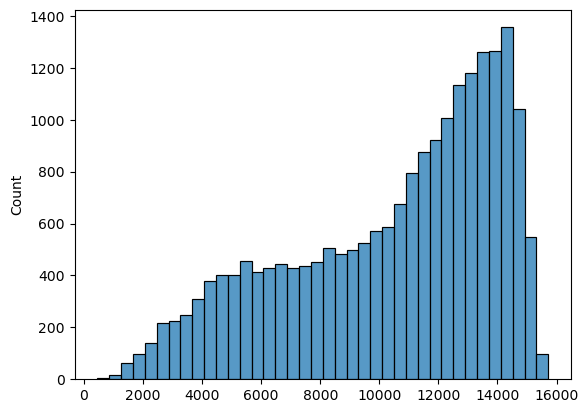

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(current_coconet.sum())

In [68]:
## Raising min group size to 2
egad_results.loc['292185at3193']

AUC                    0.439362
AVG_NODE_DEGREE    12449.040782
DEGREE_NULL_AUC        0.839760
P_Value                0.321895
Name: 292185at3193, dtype: float64

In [30]:
egad_results.loc['871799at3193']

KeyError: '871799at3193'

In [27]:
wide_version_of_orthogroups['292185at3193'].sum()

4.0

In [22]:
## Default 

egad_results.loc['292185at3193']

AUC                    0.439362
AVG_NODE_DEGREE    12449.040782
DEGREE_NULL_AUC        0.839760
P_Value                0.321895
Name: 292185at3193, dtype: float64

In [18]:
egad_dataframe

,rice_jp AUC,rice_jp P_Value
10009at3193,NaN,NaN
10051at3193,NaN,NaN
10092at3193,NaN,NaN
10147at3193,NaN,NaN
1018at3193,NaN,NaN
...,...,...
9842at3193,NaN,NaN
9877at3193,NaN,NaN
9919at3193,NaN,NaN
9942at3193,0.643618,0.192945


In [26]:
egad_dataframe.to_csv('/home/passala/passala/Generated_Tables/Comparing_all_go_groups_across_species/Ortho_cross_all_tables/egad_scores_orthogroups.csv')

In [ ]:
current_species_groups

In [ ]:
current_species_groups.loc[current_species_groups['Symbol'] == "AT1G71040"]